In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

In [3]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [4]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}
play_types_seasons_players = {}

    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='T', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict


def download_play_type_data_player(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons_players:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons_players[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons_players[season]

    
    return play_type_dict



In [5]:
last_year = download_play_type_data(season='2020-21')

Retrieving play types...


In [6]:
cur_year = download_play_type_data(season='2021-22')

Retrieving play types...


In [7]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["TEAM_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='TEAM_NAME')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='TEAM_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [8]:
last_df = get_interesting_data(last_year, 'PTS')
cur_df = get_interesting_data(cur_year, 'PTS')

In [9]:
target_stat = 'PTS'
merged_df = get_merged_data(last_year, cur_year, target_stat)

In [10]:
diff_columns = [item for item in merged_df.columns.tolist() if '_diff' in item]

In [11]:
merged_df.loc[:, "EUCLIDEAN_DISTANCE"] = merged_df.loc[:, diff_columns].abs().sum(axis=1) ** (1/2)

In [12]:
merged_df.loc[:, "COSINE_SIMILARITY"] = merged_df.DOT_PRODUCT / (merged_df.LAST_NORM * merged_df.CUR_NORM)

In [13]:
merged_df.sort_values(by='COSINE_SIMILARITY')

,TEAM_NAME,PTS_PRBallHandler_last,PTS_Isolation_last,PTS_Transition_last,PTS_Spotup_last,PTS_Handoff_last,PTS_OffScreen_last,PTS_Cut_last,PTS_OffRebound_last,PTS_Postup_last,...,OffScreen_diff,Cut_diff,OffRebound_diff,Postup_diff,PRRollman_diff,LAST_NORM,CUR_NORM,DOT_PRODUCT,EUCLIDEAN_DISTANCE,COSINE_SIMILARITY
27,Washington Wizards,14.0,7.7,24.9,22.9,4.1,6.4,13.0,5.9,6.7,...,3.24,1.69,0.81,6.25,3.24,41.725172,39.268817,1584.69,10.660675,0.967160
9,Orlando Magic,19.5,3.6,14.6,22.9,6.6,5.5,7.3,6.9,5.4,...,2.89,7.29,0.36,3.24,6.25,37.441822,38.867853,1421.91,8.293371,0.977068
19,Indiana Pacers,15.8,4.5,23.9,26.2,7.9,4.8,11.6,6.2,3.7,...,1.96,1.21,2.25,0.16,10.24,42.917712,40.719283,1709.32,9.019423,0.978108
3,Portland Trail Blazers,22.9,11.9,14.6,23.5,5.9,4.7,7.8,7.5,5.7,...,0.00,1.21,1.96,4.41,0.49,41.160175,39.471635,1591.98,8.258935,0.979885
7,Boston Celtics,19.8,7.3,18.5,26.2,5.5,4.9,9.2,6.9,4.4,...,0.00,1.96,0.36,0.01,1.21,41.452744,42.853121,1742.99,8.290959,0.981204
8,LA Clippers,19.8,8.1,15.2,31.5,3.1,5.0,8.1,6.1,6.8,...,0.64,2.25,1.21,3.24,0.49,43.713270,39.143199,1683.21,8.753285,0.983714
16,Toronto Raptors,17.1,5.7,23.1,27.1,5.2,5.2,8.4,5.8,2.4,...,5.29,1.44,3.61,4.00,4.84,42.564304,39.333446,1647.75,7.958643,0.984201
13,Chicago Bulls,18.3,4.2,15.8,27.0,4.9,3.6,12.5,5.7,6.1,...,0.16,15.21,0.36,1.21,0.49,40.949969,42.633789,1720.32,7.341662,0.985375
15,Philadelphia 76ers,17.4,5.7,20.8,25.4,5.4,2.3,6.8,7.2,11.8,...,0.04,0.01,1.96,7.29,0.81,41.497349,40.939956,1676.75,6.679072,0.986962
1,Dallas Mavericks,23.1,6.4,14.7,27.6,5.3,5.0,7.1,5.2,5.3,...,6.25,1.69,1.96,0.04,0.64,42.269847,40.336212,1689.00,5.979130,0.990613


In [14]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item for item in range(0, 40, 5)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    ax.set_yticks([item for item in range(0, 35, 5)])
    ax.set_yticklabels([f"{item}" for item in range(0, 35, 5)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

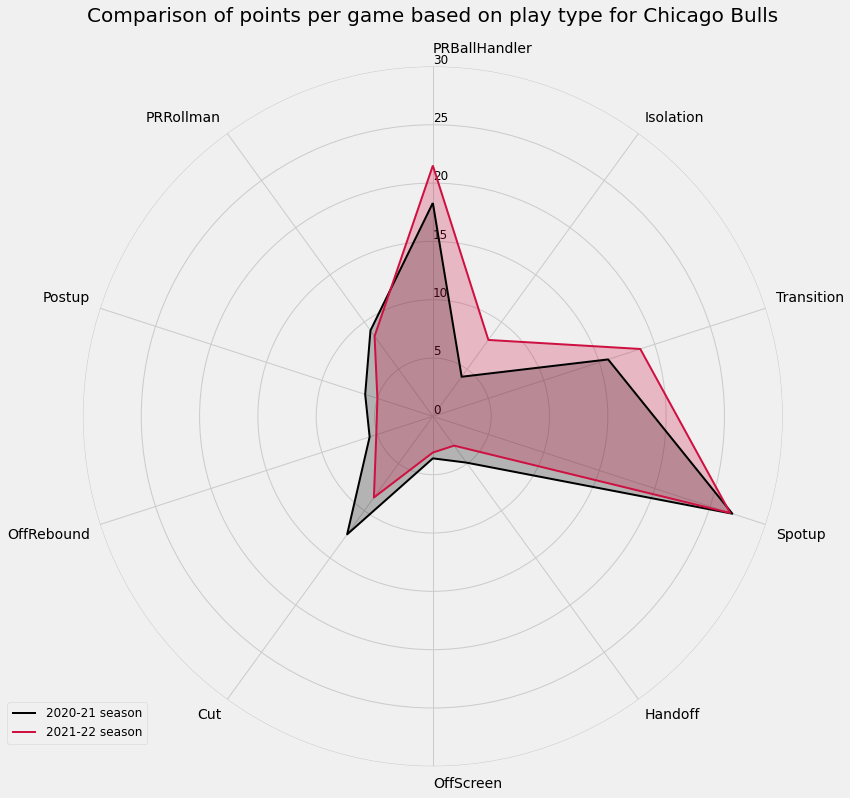

In [31]:
team_name = 'Chicago Bulls'
team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
team_cur = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'cur' in column]]

team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Comparison of points per game based on play type for {team_name}",
    data=[team_last.iloc[0], team_cur.iloc[0]],
    labels=["2020-21 season", "2021-22 season"],
    colors=[
        "#000000",
        "#CE1141"
    ],
    alphas=[0.25, 0.25]
)

In [15]:
plt.style.use('fivethirtyeight')

In [16]:
merged_df.sort_values(by='COSINE_SIMILARITY')

,TEAM_NAME,PTS_PRBallHandler_last,PTS_Isolation_last,PTS_Transition_last,PTS_Spotup_last,PTS_Handoff_last,PTS_OffScreen_last,PTS_Cut_last,PTS_OffRebound_last,PTS_Postup_last,...,OffScreen_diff,Cut_diff,OffRebound_diff,Postup_diff,PRRollman_diff,LAST_NORM,CUR_NORM,DOT_PRODUCT,EUCLIDEAN_DISTANCE,COSINE_SIMILARITY
27,Washington Wizards,14.0,7.7,24.9,22.9,4.1,6.4,13.0,5.9,6.7,...,3.24,1.69,0.81,6.76,3.24,41.725172,39.102046,1577.72,10.701402,0.967013
9,Orlando Magic,19.5,3.6,14.6,22.9,6.6,5.5,7.3,6.9,5.4,...,2.89,7.29,0.36,3.24,6.25,37.441822,38.932249,1424.20,8.319255,0.977022
19,Indiana Pacers,15.8,4.5,23.9,26.2,7.9,4.8,11.6,6.2,3.7,...,1.96,1.21,2.25,0.16,10.24,42.917712,40.847277,1714.56,9.017206,0.978032
7,Boston Celtics,19.8,7.3,18.5,26.2,5.5,4.9,9.2,6.9,4.4,...,0.01,1.96,0.36,0.01,1.21,41.452744,42.804205,1739.44,8.464632,0.980324
3,Portland Trail Blazers,22.9,11.9,14.6,23.5,5.9,4.7,7.8,7.5,5.7,...,0.00,1.44,2.25,4.00,0.36,41.160175,39.212881,1583.83,8.009370,0.981302
8,LA Clippers,19.8,8.1,15.2,31.5,3.1,5.0,8.1,6.1,6.8,...,0.64,2.25,1.21,3.24,0.49,43.713270,39.271236,1689.51,8.605812,0.984176
16,Toronto Raptors,17.1,5.7,23.1,27.1,5.2,5.2,8.4,5.8,2.4,...,5.29,1.21,3.61,4.00,4.84,42.564304,39.532139,1656.21,7.879721,0.984282
13,Chicago Bulls,18.3,4.2,15.8,27.0,4.9,3.6,12.5,5.7,6.1,...,0.25,15.21,0.36,1.21,0.36,40.949969,42.570295,1717.30,7.384443,0.985113
15,Philadelphia 76ers,17.4,5.7,20.8,25.4,5.4,2.3,6.8,7.2,11.8,...,0.01,0.01,2.25,6.76,1.00,41.497349,40.734261,1670.57,6.337981,0.988290
17,Cleveland Cavaliers,16.4,4.6,17.4,21.3,4.9,4.0,12.3,6.7,4.1,...,0.04,0.49,0.09,6.76,0.36,36.781245,38.508700,1403.28,5.405553,0.990739


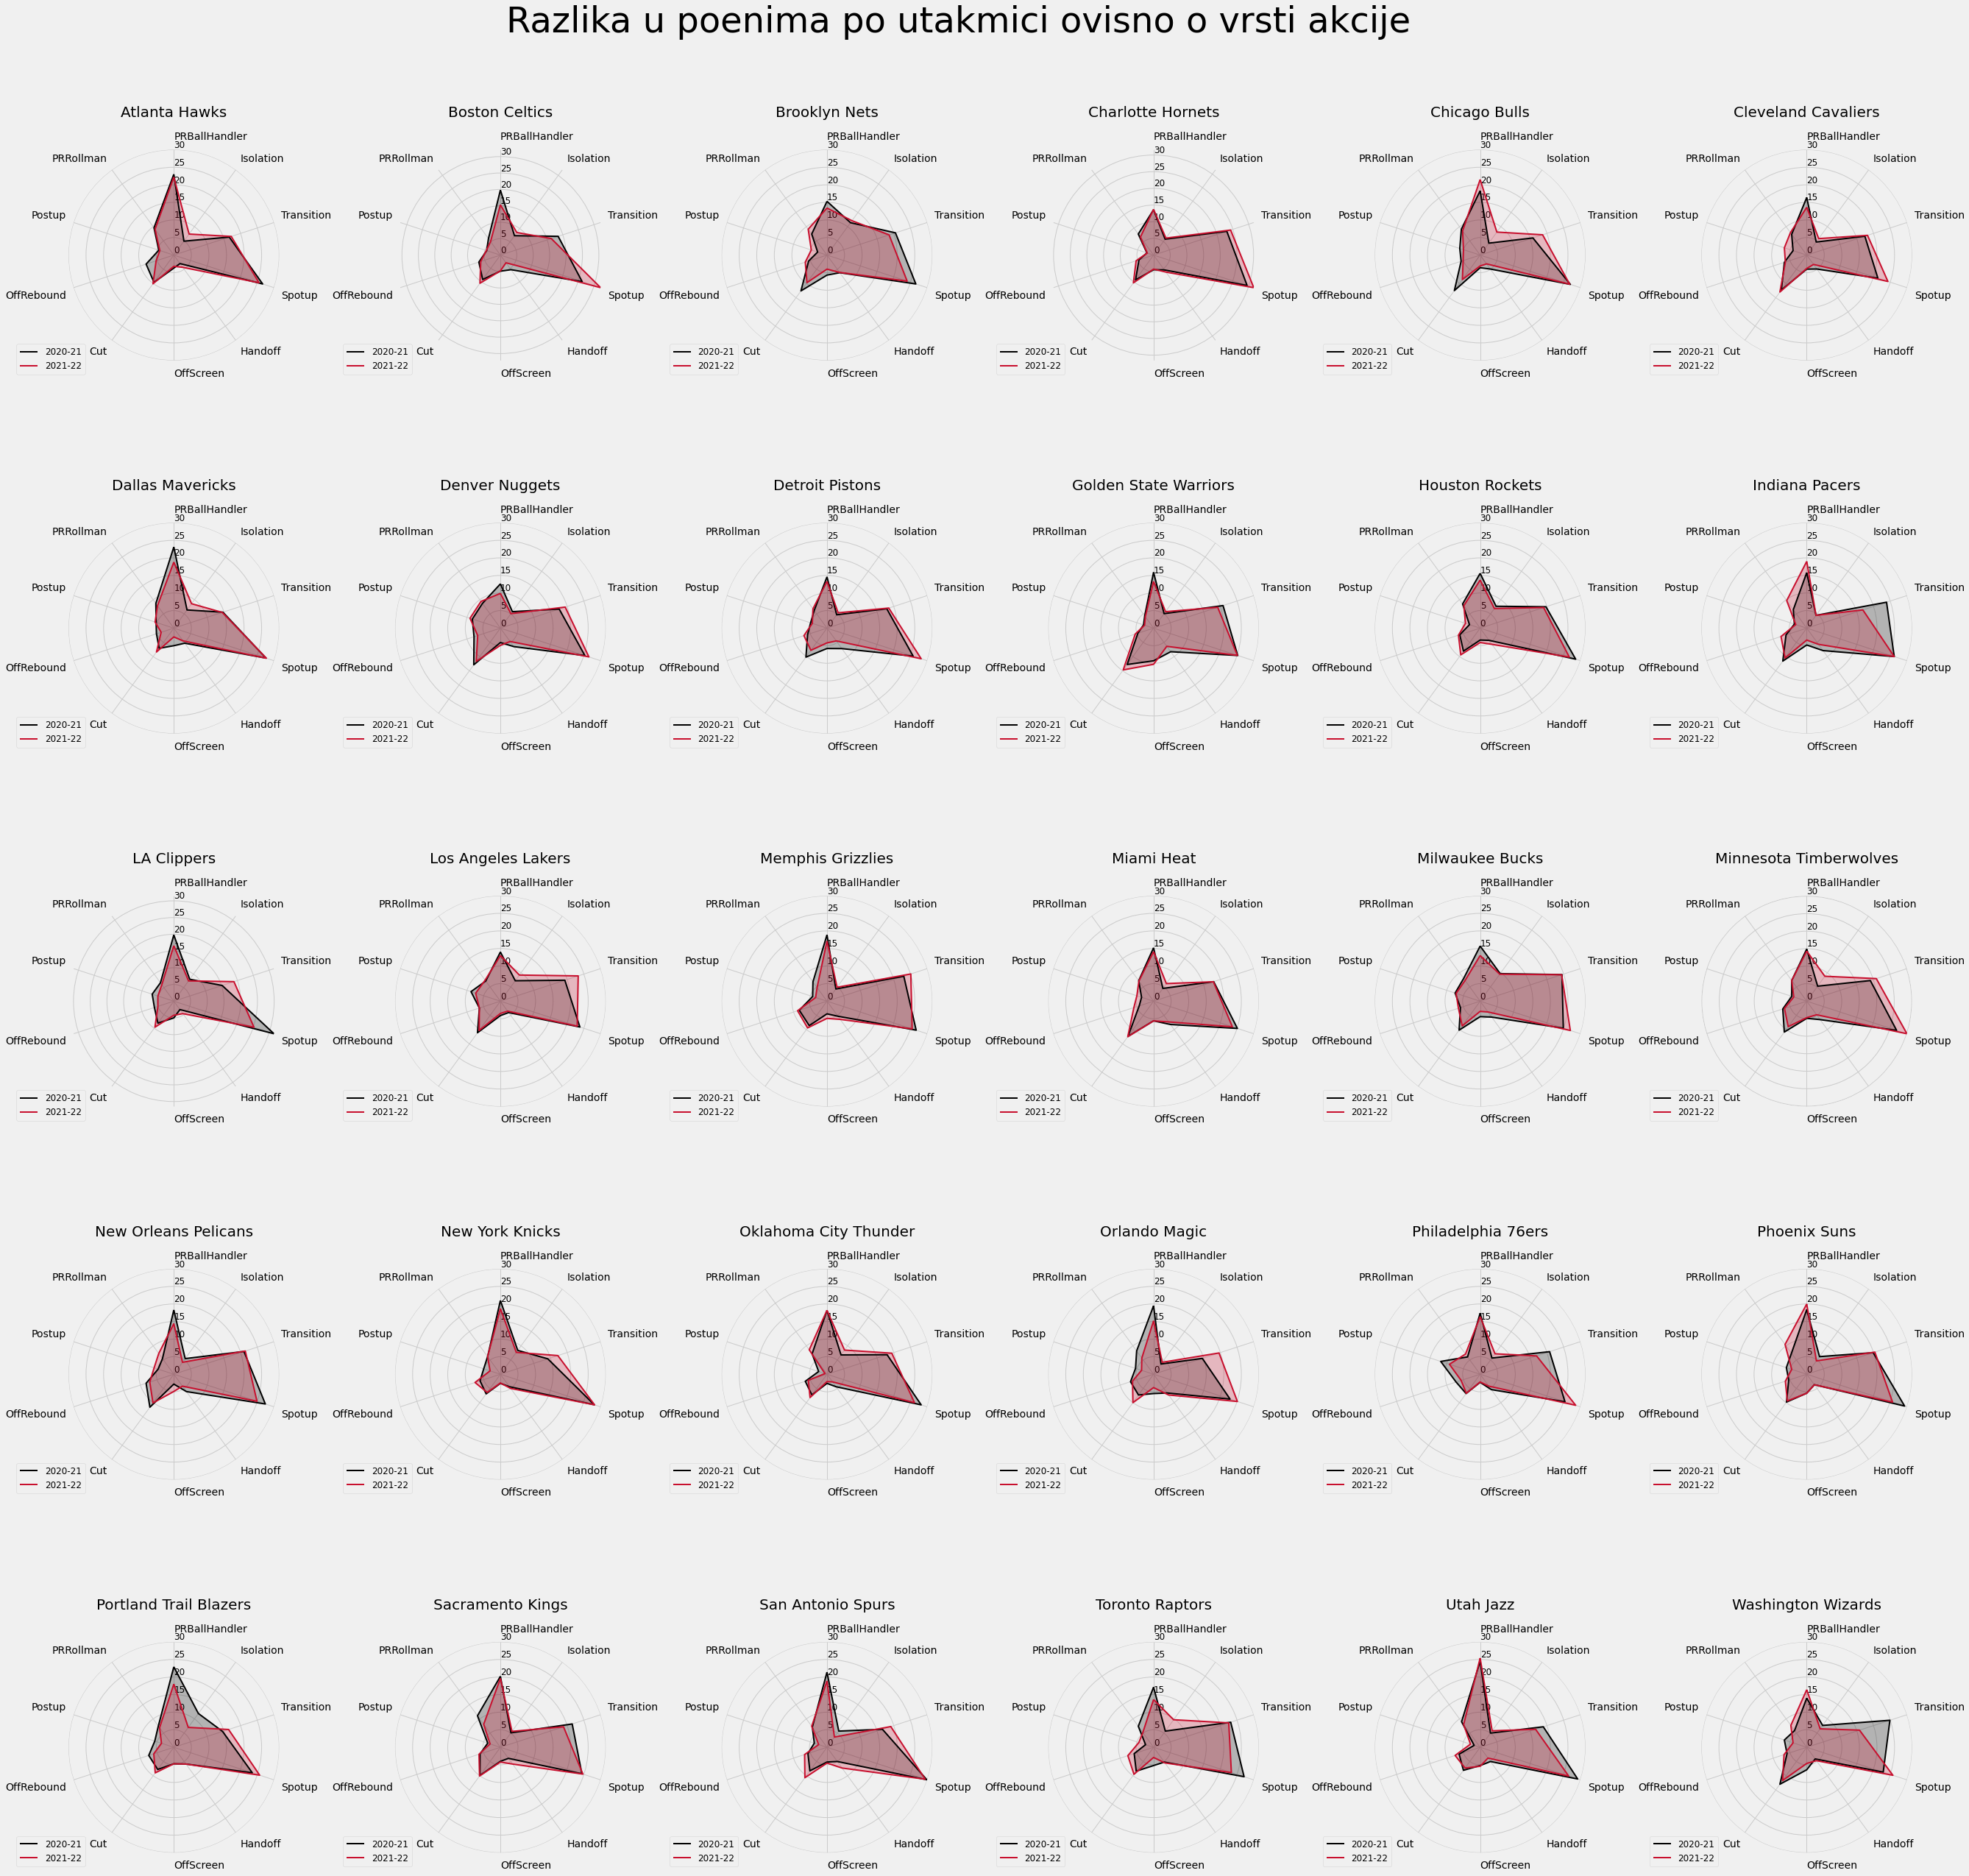

In [32]:
fig, axes = plt.subplots(5, 6, figsize=(40, 40), subplot_kw=dict(polar=True))

axes = axes.flatten()
merged_df = merged_df.sort_values(by='TEAM_NAME')
for index in range(len(merged_df)):
    item = merged_df.iloc[index]
    hou_last = merged_df.loc[merged_df.TEAM_NAME == item.TEAM_NAME, [column for column in merged_df.columns.tolist() if 'last' in column]]
    hou_cur = merged_df.loc[merged_df.TEAM_NAME == item.TEAM_NAME, [column for column in merged_df.columns.tolist() if 'cur' in column]]

    hou_last = hou_last.rename(columns={item: item.split("_last")[0].split("PTS_")[1] for item in hou_last.columns})
    hou_cur = hou_cur.rename(columns={item: item.split("_cur")[0].split("PTS_")[1] for item in hou_cur.columns})
    cur_ax = axes[index]
    plot_radar(
        title=f"{item.TEAM_NAME}",
        data=[hou_last.iloc[0], hou_cur.iloc[0]],
        labels=["2020-21", "2021-22"],
        colors=[
            "#000000",
            "#C8102E"
        ],
        alphas=[0.25, 0.25],
        ax=cur_ax
    )
    axes[index] = cur_ax
    
plt.suptitle("Razlika u poenima po utakmici ovisno o vrsti akcije", size=48)
plt.subplots_adjust(wspace=0.55, hspace=0.00001, top=0.95)
plt.savefig('radar_diff.png', dpi=120, bbox_inches='tight')

In [54]:
teams = [
    'Phoenix Suns',
    'Memphis Grizzlies',
    'Golden State Warriors',
    'Utah Jazz',
    'Miami Heat',
    'Milwaukee Bucks',
    'Philadelphia 76ers',
    'Boston Celtics'
]

team_colors = {
    'Boston Celtics': '#007A33',
    'Phoenix Suns': '#E56020',
    'Memphis Grizzlies': '#5D76A9',
    'Golden State Warriors': '#1D428A',
    'Utah Jazz': '#002B5C',
    'Miami Heat': '#98002E',
    'Milwaukee Bucks': '#00471B',
    'Philadelphia 76ers': '#006BB6',
}

In [55]:
subset_df = merged_df.loc[merged_df.TEAM_NAME.isin(teams)]

In [56]:
subset_df.loc[:, 'COLOR'] = [team_colors[name] for name in subset_df.TEAM_NAME.unique()]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


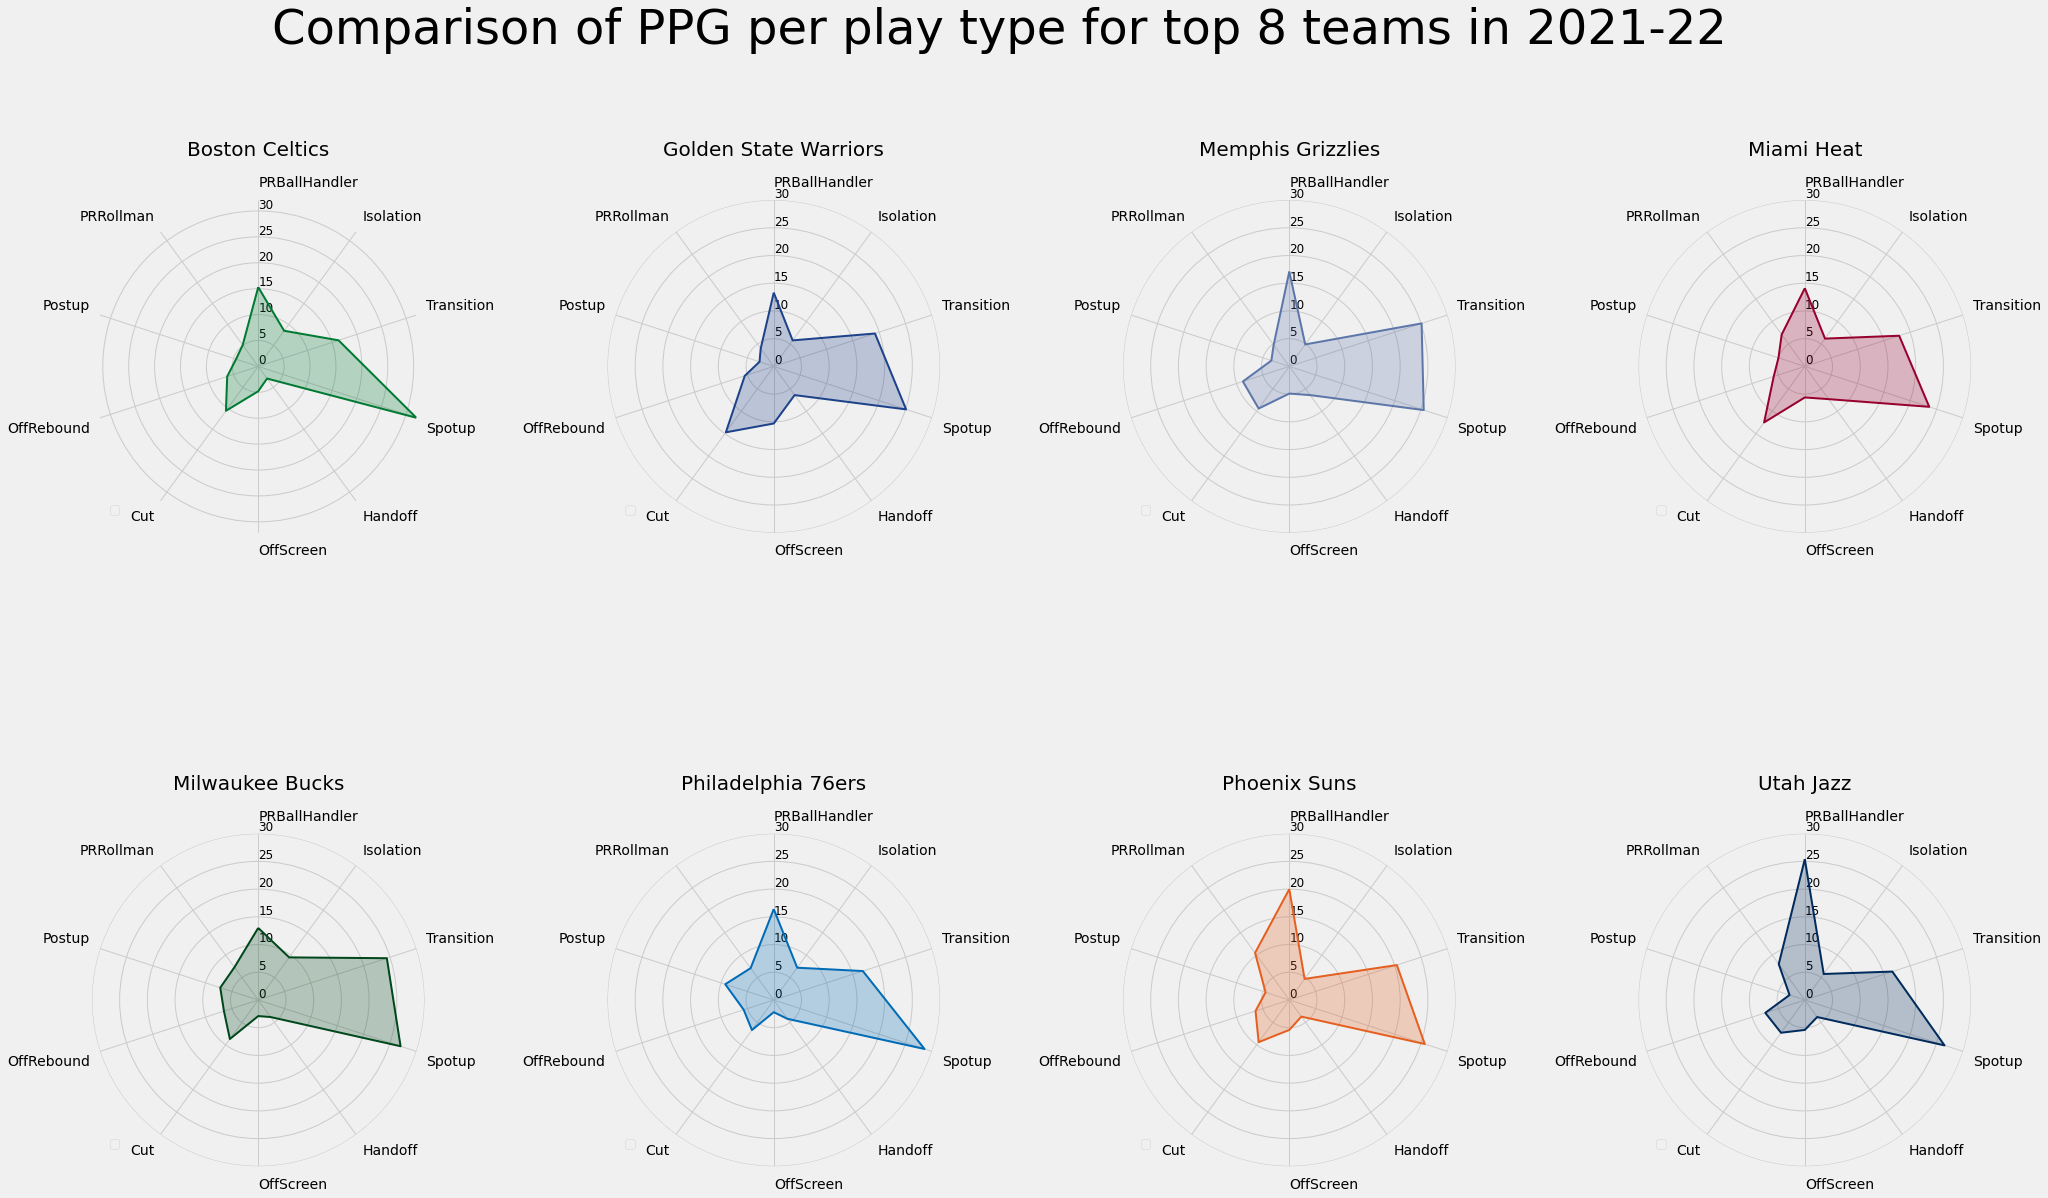

In [73]:
fig, axes = plt.subplots(2, 4, figsize=(30, 20), subplot_kw=dict(polar=True))

axes = axes.flatten()
subset_df = subset_df.sort_values(by='TEAM_NAME')
for index in range(len(subset_df)):
    item = subset_df.iloc[index]
    team_cur = subset_df.loc[subset_df.TEAM_NAME == item.TEAM_NAME, [column for column in subset_df.columns.tolist() if 'cur' in column]]

    team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split("PTS_")[1] for item in team_cur.columns})
    cur_ax = axes[index]
    plot_radar(
        title=f"{item.TEAM_NAME}",
        data=[team_cur.iloc[0]],
        labels=[""],
        colors=[
            item.COLOR,
        ],
        alphas=[0.25],
        ax=cur_ax
    )
    axes[index] = cur_ax
    
plt.suptitle("Comparison of PPG per play type for top 8 teams in 2021-22", size=48)
plt.subplots_adjust(wspace=0.55, hspace=0, top=0.95)
plt.savefig('radar_diff.png', dpi=120, bbox_inches='tight')

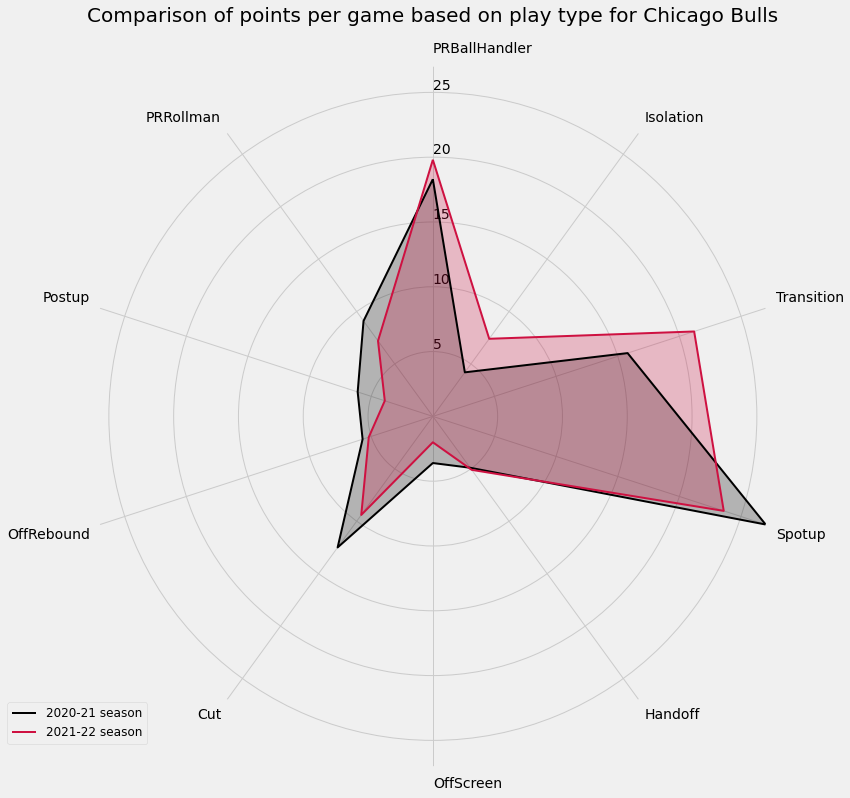

In [17]:
team_name = 'Chicago Bulls'
team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
team_cur = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'cur' in column]]

team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Comparison of points per game based on play type for {team_name}",
    data=[team_last.iloc[0], team_cur.iloc[0]],
    labels=["2020-21 season", "2021-22 season"],
    colors=[
        "#000000",
        "#CE1141"
    ],
    alphas=[0.25, 0.25]
)

## PLAYER

In [8]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats


In [9]:
players_regular_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame').get_data_frames()[0]

In [10]:
player_names_only = players_regular_stats.loc[:, ['PLAYER_ID', 'PLAYER_NAME']]

In [11]:
def get_interesting_data_player(df, target_column, players):
    final_df = None
    for player in players:
        cur_row = {
            'PLAYER_NAME': player
        }
        for index, play in enumerate(play_types):
            columns = ["PLAYER_NAME", target_column]
            cur_play_df = df[play]
            result = cur_play_df.loc[cur_play_df.PLAYER_NAME == player]
            if len(result) == 0:
                cur_row[f"{target_column}_{play}"] = 0.0
            elif len(result) == 1:
                cur_row[f"{target_column}_{play}"] = result.iloc[0][target_column]
            else:
                if target_column == 'PTS':
                    final_pts = (result[target_column] * result['GP']).sum() / result['GP'].sum()
                    cur_row[f"{target_column}_{play}"] = final_pts
                elif target_column == 'PPP':
                    final_pts = (result[target_column] * result['PPP']).sum() / result['PPP'].sum()
                    cur_row[f"{target_column}_{play}"] = final_pts
                else:
                    cur_row[f"{target_column}_{play}"] = result[target_column].mean()
        if final_df is None:
            final_df = pd.DataFrame([cur_row])
        else:
            final_df = pd.concat([final_df, pd.DataFrame([cur_row])])
            #final_df = pd.merge(left=final_df, right=result, on=['PLAYER_ID', 'PLAYER_NAME']).fillna(0.0)
    return final_df


def get_merged_data_player(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    first_year_players = set()
    for play in play_types:
        cur_df = first_year[play]
        first_year_players = first_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))
    
    first_df = get_interesting_data_player(first_year, target_column, players=first_year_players)
    
    second_year_players = set()
    for play in play_types:
        cur_df = second_year[play]
        second_year_players = second_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))
    
    second_df = get_interesting_data_player(second_year, target_column, players=second_year_players)
    
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [12]:
two_year_diff = download_play_type_data_player(season='2019-20')

Retrieving play types...


In [13]:
last_year = download_play_type_data_player(season='2020-21')

cur_year = download_play_type_data_player(season='2021-22')

Retrieving play types...
Retrieving play types...


In [14]:
first_year_players = set()
for play in play_types:
    cur_df = last_year[play]
    first_year_players = first_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))

second_year_players = set()
for play in play_types:
    cur_df = cur_year[play]
    second_year_players = second_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))

In [15]:
two_year_df = get_interesting_data_player(two_year_diff, 'PTS', first_year_players)
last_df = get_interesting_data_player(last_year, 'PTS', first_year_players)
cur_df = get_interesting_data_player(cur_year, 'PTS', second_year_players)

target_stat = 'PTS'
merged_df = get_merged_data_player(last_year, cur_year, target_stat)

diff_columns = [item for item in merged_df.columns.tolist() if '_diff' in item]

merged_df.loc[:, "EUCLIDEAN_DISTANCE"] = merged_df.loc[:, diff_columns].abs().sum(axis=1) ** (1/2)

merged_df.loc[:, "COSINE_SIMILARITY"] = merged_df.DOT_PRODUCT / (merged_df.LAST_NORM * merged_df.CUR_NORM)

In [16]:
cur_df.loc[cur_df.PLAYER_NAME == 'Tyrese Haliburton']

,PLAYER_NAME,PTS_PRBallHandler,PTS_Isolation,PTS_Transition,PTS_Spotup,PTS_Handoff,PTS_OffScreen,PTS_Cut,PTS_OffRebound,PTS_Postup,PTS_PRRollman
0,Tyrese Haliburton,5.967164,1.634328,2.691045,2.719403,0.643284,0.3,0.0,0.4,0.0,0.0


In [17]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 45, 10)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 45, 10)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [18]:
plt.style.use('fivethirtyeight')

In [19]:
third_df = two_year_df.loc[two_year_df.PLAYER_NAME == 'LeBron James']


In [20]:
third_df.iloc[0][1:]

PTS_PRBallHandler    6.9
PTS_Isolation          4
PTS_Transition       5.6
PTS_Spotup           1.6
PTS_Handoff          0.7
PTS_OffScreen        0.9
PTS_Cut              1.2
PTS_OffRebound         1
PTS_Postup           2.5
PTS_PRRollman        0.2
Name: 0, dtype: object

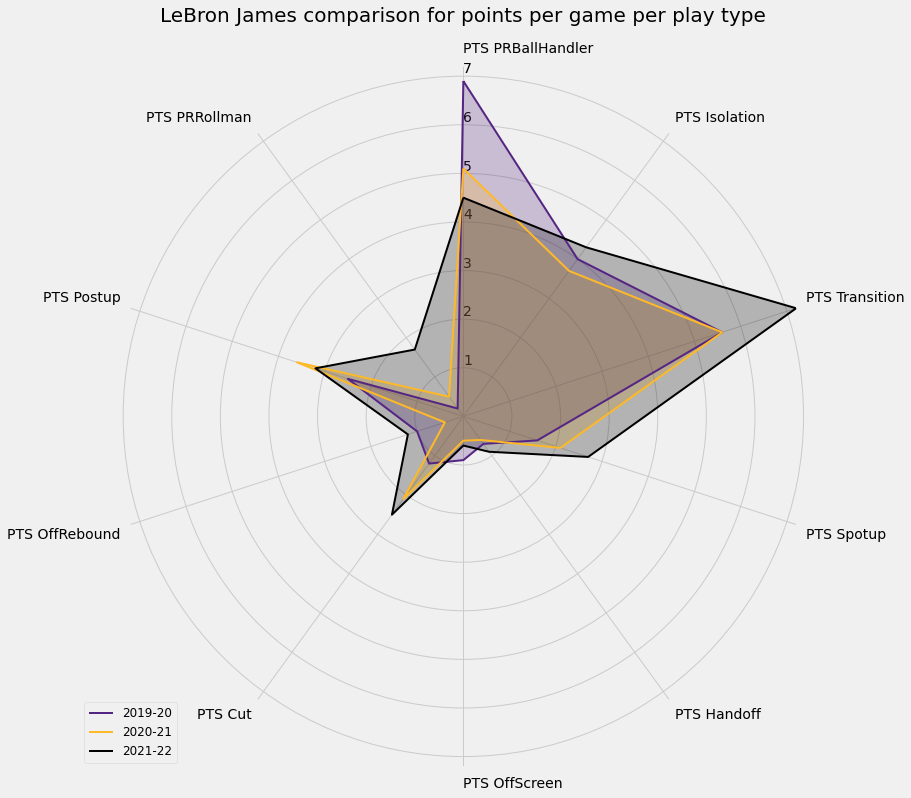

In [21]:
#category = 'PTS'
#cur_df = get_interesting_data(cur_year, category)
player_name = 'LeBron James'
player_name_second = player_name
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = last_df.loc[last_df.PLAYER_NAME == player_name]
second_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_second]
third_df = two_year_df.loc[two_year_df.PLAYER_NAME == 'LeBron James']

#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"{player_name} comparison for points per game per play type",
    data=[third_df.iloc[0][1:], first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=['2019-20', '2020-21', '2021-22'],
    colors=[
        '#552583',
        '#FDB927',
        '#000000'
    ],
    alphas=[0.25, 0.25, 0.25]
)

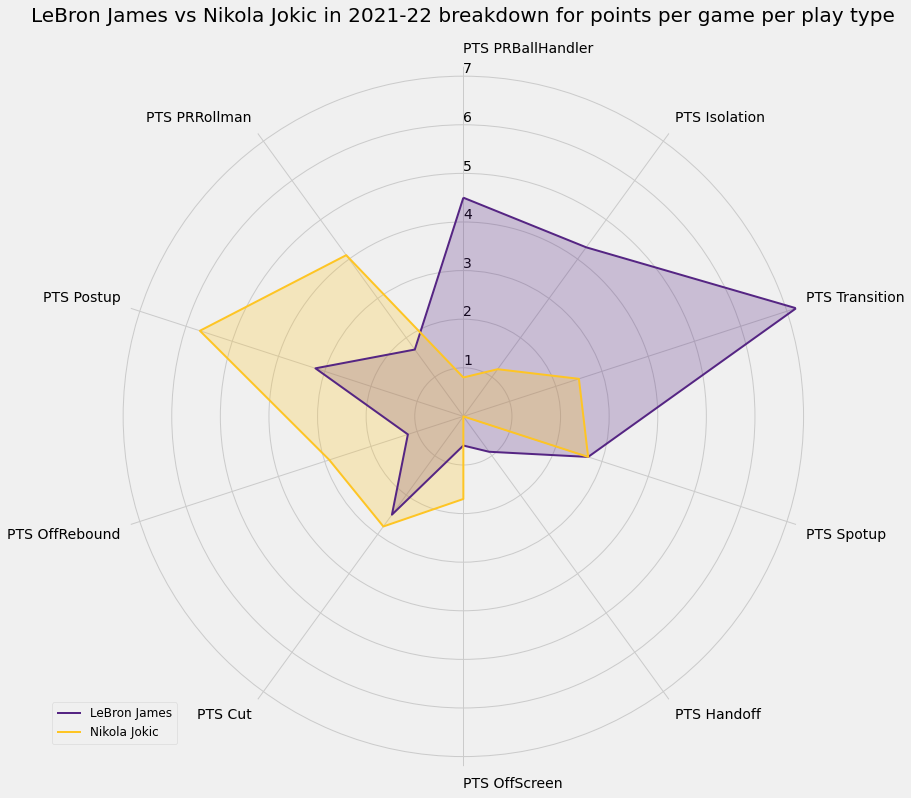

In [22]:
#category = 'PTS'
#cur_df = get_interesting_data(cur_year, category)
player_name = 'LeBron James'
player_name_second = 'Nikola Jokic'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = cur_df.loc[cur_df.PLAYER_NAME == player_name]
second_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_second]


#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"{player_name} vs {player_name_second} in 2021-22 breakdown for points per game per play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=[player_name, player_name_second],
    colors=[
        '#552583',
        '#FEC524',
    ],
    alphas=[0.25, 0.25]
)

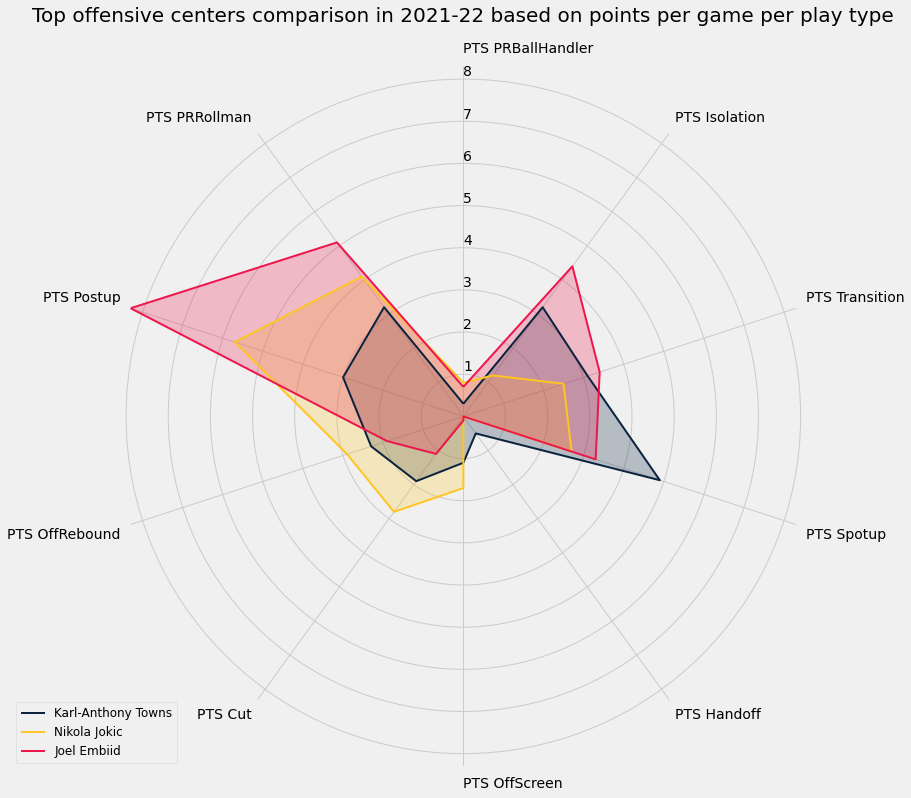

In [31]:
#category = 'PTS'
#cur_df = get_interesting_data(cur_year, category)
player_name = 'Karl-Anthony Towns'
player_name_second = 'Nikola Jokic'
player_name_third = 'Joel Embiid'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = cur_df.loc[cur_df.PLAYER_NAME == player_name]
second_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_second]
third_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_third]


#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Top offensive centers comparison in 2021-22 based on points per game per play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:], third_df.iloc[0][1:]],
    labels=[player_name, player_name_second, player_name_third],
    colors=[
        '#0C2340',
        '#FEC524',
        '#ED174C'
    ],
    alphas=[0.25, 0.25, 0.25]
)

In [23]:
minutes_names_only = players_regular_stats.loc[:, ['PLAYER_NAME', 'GP', 'MIN']]

In [24]:
merged_df = pd.merge(left=merged_df, right=minutes_names_only, on='PLAYER_NAME')

In [25]:
merged_df = merged_df.loc[(merged_df.GP > 15) & (merged_df.MIN >= 30)]

In [26]:
merged_df.sort_values(by='COSINE_SIMILARITY')

,PLAYER_NAME,PTS_PRBallHandler_last,PTS_Isolation_last,PTS_Transition_last,PTS_Spotup_last,PTS_Handoff_last,PTS_OffScreen_last,PTS_Cut_last,PTS_OffRebound_last,PTS_Postup_last,...,OffRebound_diff,Postup_diff,PRRollman_diff,LAST_NORM,CUR_NORM,DOT_PRODUCT,EUCLIDEAN_DISTANCE,COSINE_SIMILARITY,GP,MIN
262,Reggie Jackson,2.300000,1.100000,1.800000,4.000000,0.400000,0.000000,0.000000,0.100000,0.000000,...,0.010000,0.000000,0.010000,5.091169,8.228609,35.400000,4.778075,0.845005,69,31.1
125,Josh Hart,0.200000,0.000000,3.000000,4.400000,0.400000,0.000000,0.000000,0.500000,0.000000,...,0.010000,0.000000,0.000000,5.367495,6.808615,32.409259,3.216943,0.886827,54,33.2
32,Jimmy Butler,6.000000,1.700000,4.100000,2.400000,1.100000,0.300000,1.600000,1.100000,1.300000,...,0.090000,1.690000,0.040000,8.274660,7.445133,56.830000,3.200000,0.922476,49,33.7
313,Desmond Bane,0.500000,0.000000,2.200000,4.200000,0.800000,0.400000,0.500000,0.000000,0.000000,...,0.160000,0.000000,0.000000,4.876474,7.463913,33.600000,3.505710,0.923138,68,30.0
177,Tobias Harris,4.200000,1.600000,4.100000,2.700000,0.800000,0.400000,0.900000,0.800000,2.700000,...,0.000000,0.490000,0.010000,7.348469,6.715653,46.000000,2.664583,0.932122,62,35.1
167,Cole Anthony,6.700000,0.900000,1.600000,1.900000,0.600000,0.000000,0.000000,0.500000,0.000000,...,0.090000,0.000000,0.000000,7.244308,7.797435,52.990000,2.701851,0.938092,59,32.5
39,Lauri Markkanen,0.300000,0.000000,1.600000,5.200000,0.400000,1.600000,1.500000,0.400000,0.700000,...,0.160000,0.640000,0.160000,6.104916,6.529931,37.510000,2.211334,0.940933,51,31.1
6,Harrison Barnes,1.500000,1.000000,2.900000,4.000000,0.900000,0.200000,1.400000,0.600000,1.500000,...,0.000000,0.810000,0.810000,5.943904,6.878227,38.690000,2.293469,0.946347,68,33.8
196,Dejounte Murray,5.600000,1.000000,3.100000,4.000000,0.300000,0.000000,0.500000,0.400000,0.000000,...,0.010000,0.000000,0.000000,7.646568,10.612728,77.150000,4.098780,0.950697,63,34.7
303,Russell Westbrook,3.800000,5.000000,5.600000,3.100000,0.200000,0.000000,0.400000,0.800000,2.000000,...,0.040000,1.000000,0.000000,9.233093,7.301370,64.100000,3.218695,0.950838,71,34.5
